## 引擎使用教程
1. 事件驱动引擎
2. 策略编写案例
3. 回测绩效输出
4. 优化策略参数

1. 事件驱动引擎
    1. 安装vnpy_fxdayu: pip install git+https://github.com/xingetouzi/vnpy_fxdayu.git@release-v1.1.19
    2. 运行逻辑

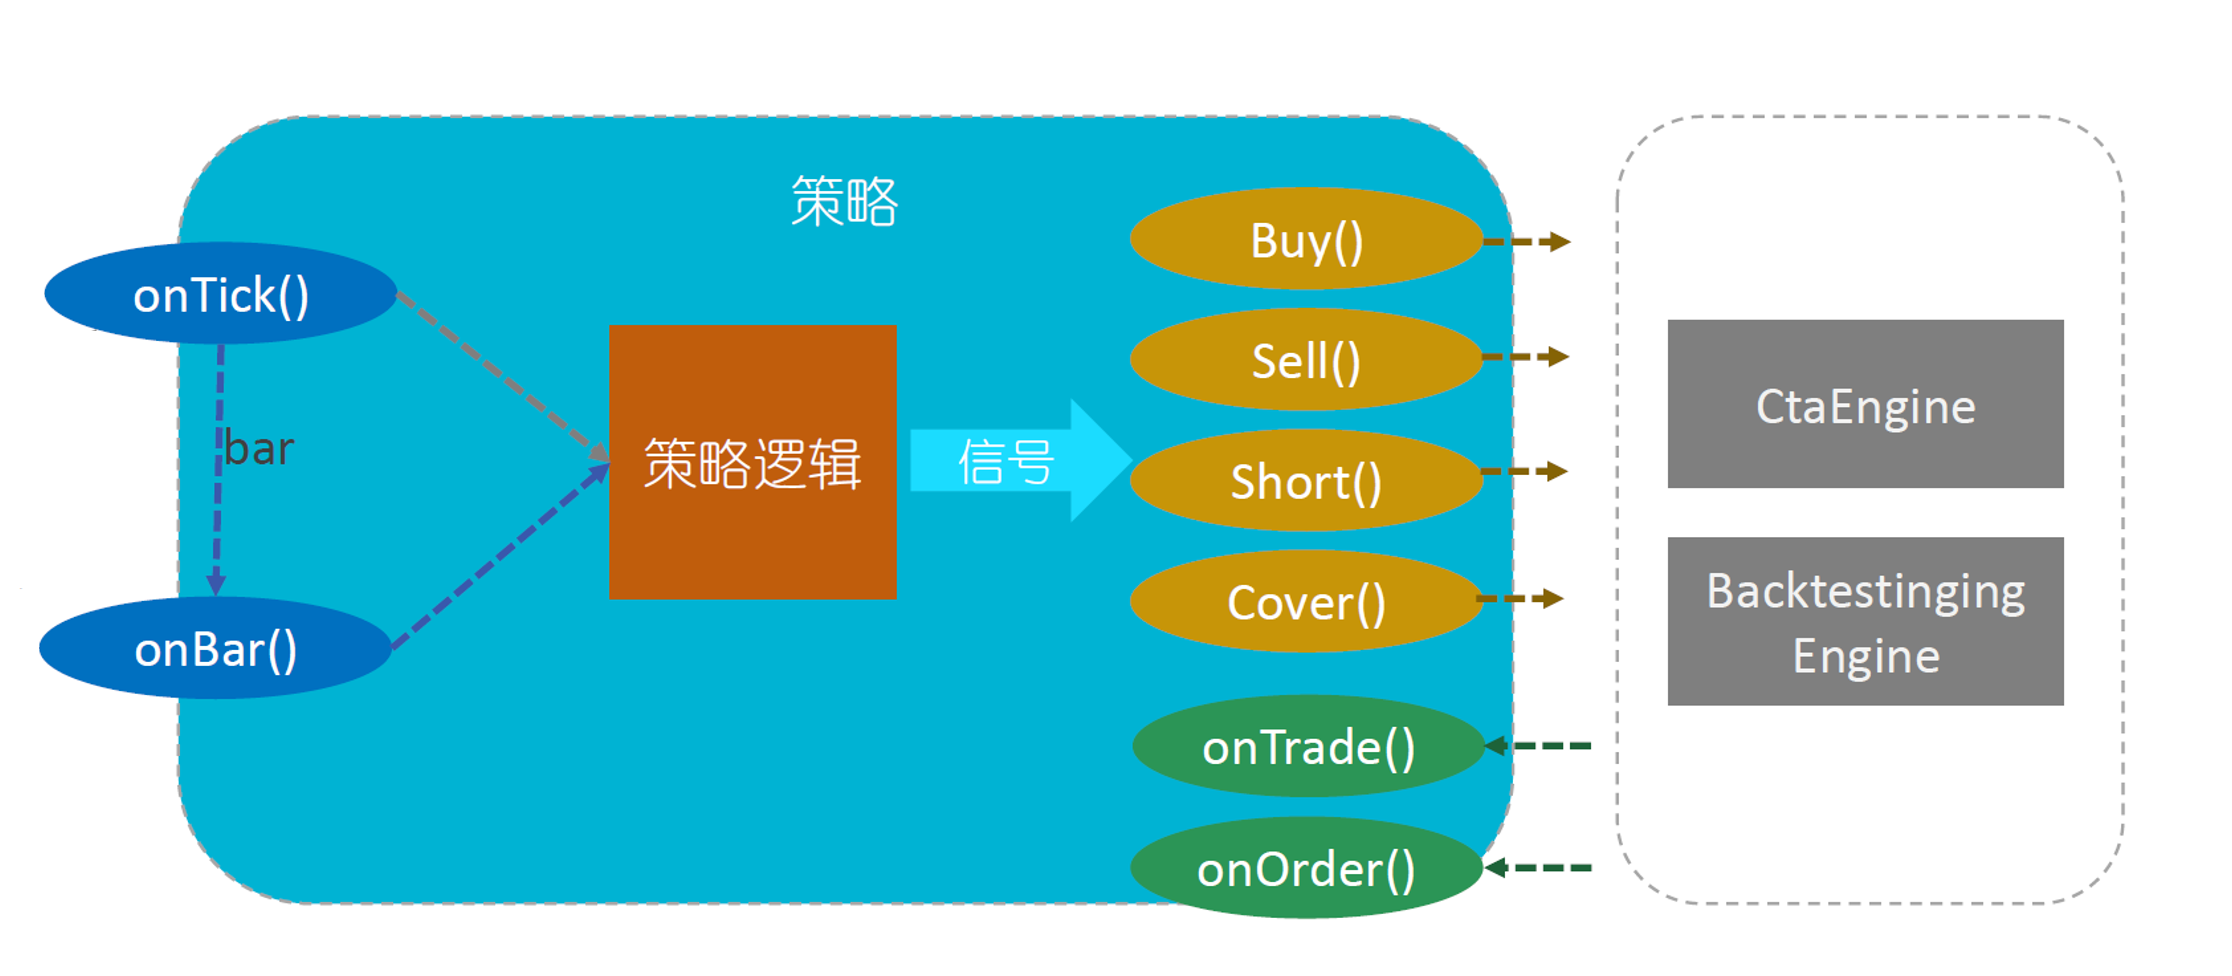

2. 策略编写案例
    1. DoubleMa_金叉死叉
    2. chartLog_画图展示
    3. TripleMa_均线过滤方向
    4. MultiFrame多周期择时

3. 策略编写步骤
    1. 设置回测模式，日期，品种数据
    2. 设置品种，手续费，滑点
    3. 设置策略参数
    4. 初始化策略
    5. 编写指标信号
    6. 下单执行
    7. 执行回测
    8. 显示回测结果

In [1]:
"""
展示如何执行策略回测。
"""
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

# 创建回测引擎
engine = BacktestingEngine()
engine.setDB_URI("mongodb://localhost:27017")

# 设置回测模式
engine.setBacktestingMode(engine.BAR_MODE)
engine.setDatabase('VnTrader_1Min_Db')

# 设置回测日期，initHours 默认值为 0
engine.setStartDate('20180201 23:00:00',initHours=10)   
engine.setEndDate('20190320 23:00:00')

# 设置品种，手续费，滑点
engine.setCapital(10000000)  # 设置起始资金，默认值是1,000,000
contracts = [{
                "symbol":"IF88:CTP",
                "size" : 1, # 每点价值
                "priceTick" : 0.1, # 最小价格变动
                "rate" : 5/10000, # 单边手续费
                "slippage" : 0.1 # 滑价
                },] 

engine.setContracts(contracts)
settingList = [{
                "symbolList": ["IF88:CTP"]
                }]   

In [2]:
"""
这里的Demo是一个最简单的双均线策略实现
"""
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
from datetime import datetime

########################################################################
# 策略继承CtaTemplate
class DoubleMaStrategy(CtaTemplate):
    """双指数均线策略Demo"""
    className = 'DoubleMaStrategy'
    author = 'ChannelCMT'
    symbolList = ["IF88:CTP"]
    
    # 策略参数
    fastPeriod = 20     # 快速均线参数
    slowPeriod = 55    # 慢速均线参数
    lot = 1             # 设置手数
    
    # 策略变量
    transactionPrice = None # 记录成交价格
    
    
    # 参数列表
    paramList = [
                 'fastPeriod',
                 'slowPeriod'
                ]    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.chartLog = {
                        'datetime':[],
                        'fastMa':[],
                        'slowMa':[]
                        }
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        
        if not am60.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        fastMa = ta.EMA(am60.close, self.fastPeriod)
        slowMa = ta.EMA(am60.close, self.slowPeriod)
        
        self.chartLog['datetime'].append(datetime.strptime(am60.datetime[-1], "%Y%m%d %H:%M:%S"))
        self.chartLog['fastMa'].append(fastMa[-1])
        self.chartLog['slowMa'].append(slowMa[-1])
        
        crossOver = (fastMa[-1]>slowMa[-1]) and (fastMa[-2]<=slowMa[-2]) # 金叉上穿 
        crossBelow = (fastMa[-1]<slowMa[-1]) and (fastMa[-2]>=slowMa[-2]) # 死叉下穿

        # 构建进出场逻辑-------------------------------------------------
        # 如果金叉时手头没有多头持仓
        if (crossOver) and (self.posDict[symbol+'_LONG']==0):
            # 如果没有空头持仓，则直接做多
            if  self.posDict[symbol+'_SHORT']==0:
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        # 如果死叉时手头没有空头持仓
        elif (crossBelow) and (self.posDict[symbol+'_SHORT']==0):
            if self.posDict[symbol+'_LONG']==0:
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [3]:
from vnpy.trader.utils import htmlplot

engine.setLog(True, "./log")
engine.initStrategy(DoubleMaStrategy, settingList[0])

# 开始跑回测
engine.runBacktesting()

C:\Users\small\Anaconda3\lib\site-packages\vnpy\trader\utils\htmlplot\core.py:8: UserWarning: Expected version of bokeh is 0.12.14, current version is 0.12.16
  warnings.warn("Expected version of bokeh is 0.12.14, current version is %s" % bokeh.__version__)


初始仓位: {'IF88:CTP_LONG': 0, 'IF88:CTP_SHORT': 0}
2019-04-30 08:45:30.740915	开始回测
2019-04-30 08:45:30.740915	策略初始化
2019-04-30 08:45:30.745442	准备载入数据：时间段:[20180201 13:00:00 , 20180201 23:00:00), 模式: bar
2019-04-30 08:45:30.895336	IF88:CTP： 从本地缓存文件实取120, 最大应取600, 还需从数据库取480
2019-04-30 08:45:31.111616	IF88:CTP： 数据库也没能补到缺失的数据
2019-04-30 08:45:31.111616	载入完成, 数据量:120
2019-04-30 08:45:31.112580	初始化预加载数据成功, 数据长度:120
2019-04-30 08:45:31.112580	策略初始化完成
2019-04-30 08:45:31.112580	策略启动完成
2019-04-30 08:45:31.112850	回测时间范围:[20180201 23:00:00,20190320 23:00:00)
2019-04-30 08:45:31.112850	当前回放的时间段:[20180201 23:00:00,20190320 23:00:00)
2019-04-30 08:45:36.655889	准备载入数据：时间段:[20180201 23:00:00 , 20190320 23:00:00), 模式: bar
2019-04-30 08:45:52.922846	IF88:CTP： 从本地缓存文件实取65040, 最大应取593280, 还需从数据库取528240
2019-04-30 08:45:58.079253	IF88:CTP： 数据库也没能补到缺失的数据
2019-04-30 08:45:58.116911	载入完成, 数据量:65040
2019-04-30 08:45:58.260557	准备载入数据：时间段:[20180201 07:51:00 , 20180203 23:01:00), 模式: bar
2019-04-30 08:45:58.482176	

2019-04-30 08:46:15.192194	计算回测结果
2019-04-30 08:46:15.211009	交割单已生成
2019-04-30 08:46:15.212136	------------------------------
2019-04-30 08:46:15.212136	第一笔交易：	2018-03-22 14:00:00
2019-04-30 08:46:15.212136	最后一笔交易：	2019-03-20 14:58:00
2019-04-30 08:46:15.212136	总交易次数：	15
2019-04-30 08:46:15.212136	总盈亏：	175.21
2019-04-30 08:46:15.212136	最大回撤: 	-805.86
2019-04-30 08:46:15.212136	平均每笔盈利：	11.68
2019-04-30 08:46:15.212136	平均每笔滑点：	0.2
2019-04-30 08:46:15.212136	平均每笔佣金：	3.45
2019-04-30 08:46:15.212136	胜率		33.33%
2019-04-30 08:46:15.212136	盈利交易平均值	237.98
2019-04-30 08:46:15.212136	亏损交易平均值	-101.47
2019-04-30 08:46:15.212136	盈亏比：	2.35
2019-04-30 08:46:16.108027	策略回测统计图已保存


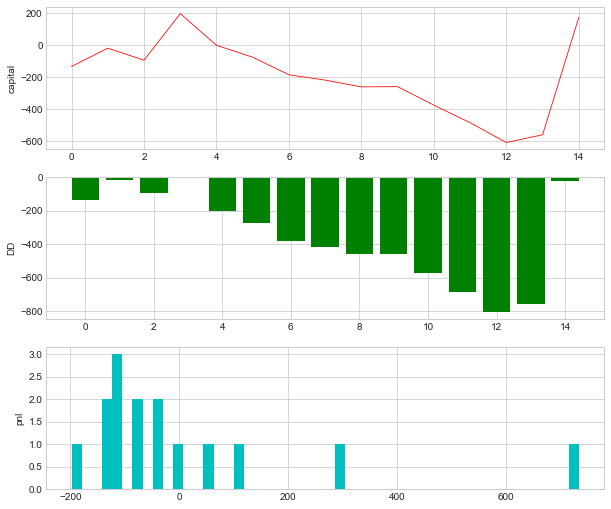

In [4]:
# 显示回测的每张订单绩效
engine.showBacktestingResult()

2019-04-30 08:46:16.798976	计算按日统计结果
2019-04-30 08:46:16.931019	------------------------------
2019-04-30 08:46:16.932108	首个交易日：	2018-02-02
2019-04-30 08:46:16.932108	最后交易日：	2019-03-20
2019-04-30 08:46:16.932108	总交易日：	271
2019-04-30 08:46:16.932108	盈利交易日	119
2019-04-30 08:46:16.932108	亏损交易日：	131
2019-04-30 08:46:16.932108	起始资金：	10000000
2019-04-30 08:46:16.932108	结束资金：	10,000,177.23
2019-04-30 08:46:16.932108	总收益率：	0.0%
2019-04-30 08:46:16.933014	年化收益：	0.0%
2019-04-30 08:46:16.933014	总盈亏：	177.23
2019-04-30 08:46:16.933014	最大回撤: 	-1,099.2
2019-04-30 08:46:16.933014	百分比最大回撤: -0.01%
2019-04-30 08:46:16.933014	总手续费：	49.87
2019-04-30 08:46:16.933014	总滑点：	2.9
2019-04-30 08:46:16.933014	总成交金额：	99,734.4
2019-04-30 08:46:16.933014	总成交笔数：	29
2019-04-30 08:46:16.933014	日均盈亏：	0.65
2019-04-30 08:46:16.933014	日均手续费：	0.18
2019-04-30 08:46:16.933014	日均滑点：	0.01
2019-04-30 08:46:16.933014	日均成交金额：	368.02
2019-04-30 08:46:16.933014	日均成交笔数：	0.11
2019-04-30 08:46:16.933014	日均收益率：	0.0%
2019-04-30 08:46:16.934

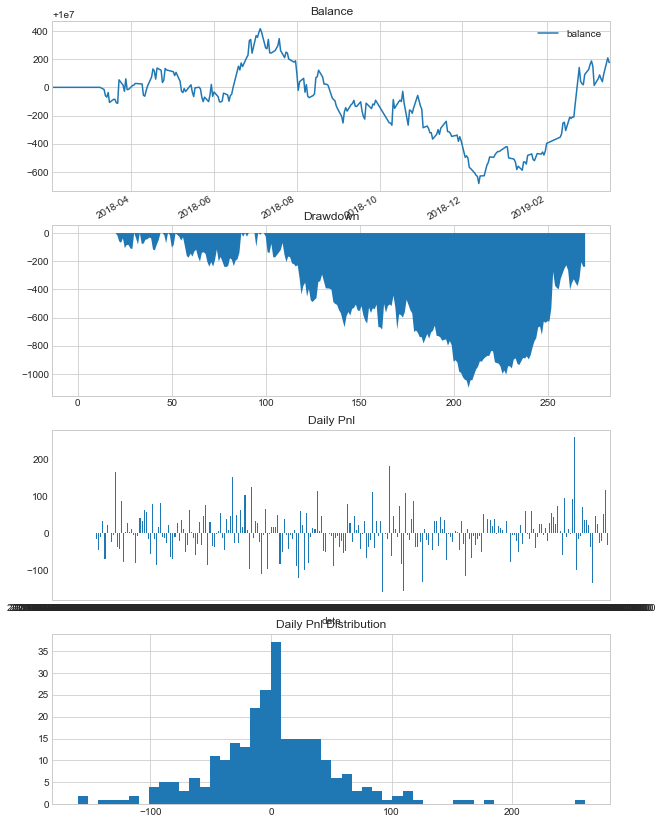

In [5]:
# 显示回测的每日绩效
engine.showDailyResult()

In [6]:
### 画图分析
chartLog = pd.DataFrame(engine.strategy.chartLog).set_index('datetime')
mp = htmlplot.getMultiPlot(engine, freq="60m")
mp.set_line(line=chartLog[['fastMa', 'slowMa']], colors={"fastMa": "red",'slowMa':'blue'}, pos=0)
mp.show()

4. 优化策略参数
    1. 单线程运行优化
    2. 多线程优化

In [7]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
engine.setLog(False)
setting.setOptimizeTarget('sharpeRatio')        # 设置优化排序的目标是夏普
setting.addParameter('fastPeriod', 20, 40, 10)    # 增加第一个优化参数，起始30，结束50，步进10
setting.addParameter('slowPeriod', 40, 80, 20)    # 增加第二个优化参数，起始60，结束30，步进10
setting.addParameter('symbolList', ['IF88:CTP']) 

In [ ]:
import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(DoubleMaStrategy, setting)

print('耗时：%s' %(time.time()-start))

2019-04-30 08:46:31.700100	------------------------------
2019-04-30 08:46:31.700635	setting: {'fastPeriod': 20, 'slowPeriod': 40, 'symbolList': ['IF88:CTP']}
初始仓位: {'IF88:CTP_LONG': 0, 'IF88:CTP_SHORT': 0}
2019-04-30 08:46:31.731978	开始回测
2019-04-30 08:46:31.731978	策略初始化
2019-04-30 08:46:31.740388	准备载入数据：时间段:[20180201 13:00:00 , 20180201 23:00:00), 模式: bar
2019-04-30 08:46:31.807730	IF88:CTP： 从本地缓存文件实取120, 最大应取600, 还需从数据库取480
2019-04-30 08:46:31.932863	IF88:CTP： 数据库也没能补到缺失的数据
2019-04-30 08:46:31.933032	载入完成, 数据量:120
2019-04-30 08:46:31.933032	初始化预加载数据成功, 数据长度:120
2019-04-30 08:46:31.933032	策略初始化完成
2019-04-30 08:46:31.933032	策略启动完成
2019-04-30 08:46:31.933032	回测时间范围:[20180201 23:00:00,20190320 23:00:00)
2019-04-30 08:46:31.933032	当前回放的时间段:[20180201 23:00:00,20190320 23:00:00)
2019-04-30 08:46:39.643934	准备载入数据：时间段:[20180201 23:00:00 , 20190320 23:00:00), 模式: bar
2019-04-30 08:47:00.165700	IF88:CTP： 从本地缓存文件实取65040, 最大应取593280, 还需从数据库取528240
2019-04-30 08:47:07.170961	IF88:CTP： 数据库也没能补到缺失的数

2019-04-30 08:50:10.657447	准备载入数据：时间段:[20180201 23:00:00 , 20190320 23:00:00), 模式: bar
2019-04-30 08:50:26.710128	IF88:CTP： 从本地缓存文件实取65040, 最大应取593280, 还需从数据库取528240
2019-04-30 08:50:31.460558	IF88:CTP： 数据库也没能补到缺失的数据
2019-04-30 08:50:31.495681	载入完成, 数据量:65040
2019-04-30 08:50:31.591423	准备载入数据：时间段:[20180201 07:51:00 , 20180203 23:01:00), 模式: bar
2019-04-30 08:50:31.688490	IF88:CTP： 从本地缓存文件实取480, 最大应取3790, 还需从数据库取3310
2019-04-30 08:50:31.711807	IF88:CTP： 数据库也没能补到缺失的数据
2019-04-30 08:50:31.712873	载入完成, 数据量:480
2019-04-30 08:50:32.232288	准备载入数据：时间段:[20171226 02:00:00 , 20180201 07:50:00), 模式: bar
2019-04-30 08:50:33.656391	IF88:CTP： 从本地缓存文件实取6240, 最大应取53630, 还需从数据库取47390
2019-04-30 08:50:34.006236	IF88:CTP： 数据库也没能补到缺失的数据
2019-04-30 08:50:34.012359	载入完成, 数据量:6240
2019-04-30 08:50:34.025267	准备载入数据：时间段:[20180203 23:02:00 , 20180204 00:00:00), 模式: bar
2019-04-30 08:50:34.025267	IF88:CTP： 从本地缓存文件实取0, 最大应取58, 还需从数据库取58
2019-04-30 08:50:34.053507	IF88:CTP： 数据库也没能补到缺失的数据
2019-04-30 08:50:34.053507	

In [ ]:
print(pd.DataFrame(resultList).sort_values(1,  ascending=False))

In [ ]:
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
# resultList = engine.runParallelOptimization(MultiFrameMaStrategy, setting)